In [10]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [11]:
import numpy as np
import tensorflow as tf
import time

import matplotlib.pyplot as plt
%matplotlib inline 

from gpflow.likelihoods import Gaussian
from gpflow.kernels import RBF, White
from gpflow.mean_functions import Constant
from gpflow.models.sgpr import SGPR, GPRFITC
from gpflow.models.svgp import SVGP
from gpflow.models.gpr import GPR
from gpflow.training import AdamOptimizer, ScipyOptimizer

from scipy.cluster.vq import kmeans2
from scipy.stats import norm
from scipy.special import logsumexp

from doubly_stochastic_dgp.dgp import DGP

In [12]:
np.random.seed(5)
# function
func = 2
# number of inducing points per layer
M = 50
notrain = 500
notest = 200
n_samples = 200
S = n_samples
def f1(x):
    return (x-0.5)**3 + np.sin(5*x) + 0.01*np.random.randn(x.shape[0], 1)

def f2(x):
    return (x-0.5)**3 + np.sin(5*x) + 0.1*np.random.randn(x.shape[0], 1)

def f3(x):
    return np.sin(5*x) + 0.05*np.random.randn(x.shape[0], 1)

def f4(x):
    return x**3 + 0.05*np.random.randn(x.shape[0], 1)

def f5(x):
    y = x.copy()
    y[y < 0.0] = 0.0
    y[y > 0.0] = 1.0
    return y + 0.05*np.random.randn(x.shape[0], 1)

funcnames = {1: 'mixed_clean',
             2: 'mixed_noisy',
             3: 'sine',
             4: 'cubic',
             5: 'step'}

X_train = np.reshape(np.linspace(-1, 1, notrain), (notrain, 1))
X_test = np.reshape(np.linspace(-1, 1, notest), (notest, 1))
X_plot = np.reshape(np.linspace(-1.5, 1.5, notest), (notest, 1))

if func == 1:
    y_train = f1(X_train)
    y_test = f1(X_test)
elif func == 2:
    y_train = f2(X_train)
    y_test = f2(X_test)
elif func == 3:
    y_train = f3(X_train)
    y_test = f3(X_test)
elif func == 4:
    y_train = f4(X_train)
    y_test = f4(X_test)
elif func == 5:
    y_train = f5(X_train)
    y_test = f5(X_test)

Y_std = np.std(y_test)

In [13]:
def make_dgp(X, Y, Z, L):
    D = X.shape[1]
    
    # the layer shapes are defined by the kernel dims, so here all hidden layers are D dimensional 
    kernels = []
    for l in range(L):
        kernels.append(RBF(D))
        
    # between layer noise (doesn't actually make much difference but we include it anyway)
    for kernel in kernels[:-1]:
        kernel += White(D, variance=1e-5) 
        
    mb = 1000 if X.shape[0] > 1000 else None 
    model = DGP(X, Y, Z, kernels, Gaussian(), num_samples=10, minibatch_size=mb)

    # start the inner layers almost deterministically 
    for layer in model.layers[:-1]:
        layer.q_sqrt = layer.q_sqrt.value * 1e-5
    
    return model

Z_M = kmeans2(X_train, M, minit='points')[0]
m_dgp2 = make_dgp(X_train, y_train, Z_M, 2)

In [14]:
def batch_assess(model, assess_model, X, Y):
    n_batches = max(int(X.shape[0]/1000.), 1)
    lik, sq_diff = [], []
    for X_batch, Y_batch in zip(np.array_split(X, n_batches), np.array_split(Y, n_batches)):
        l, sq = assess_model(model, X_batch, Y_batch)
        lik.append(l)
        sq_diff.append(sq)
    lik = np.concatenate(lik, 0)
    sq_diff = np.array(np.concatenate(sq_diff, 0), dtype=float)
    return np.average(lik), np.average(sq_diff)**0.5

def assess_single_layer(model, X_batch, Y_batch):
    m, v = model.predict_y(X_batch)
    lik = np.sum(norm.logpdf(Y_batch*Y_std, loc=m*Y_std, scale=Y_std*v**0.5),  1)
    sq_diff = Y_std**2*((m - Y_batch)**2)
    return lik, sq_diff 


def assess_sampled(model, X_batch, Y_batch):
    m, v = model.predict_y(X_batch, S)
    S_lik = np.sum(norm.logpdf(Y_batch*Y_std, loc=m*Y_std, scale=Y_std*v**0.5), 2)
    lik = logsumexp(S_lik, 0, b=1/float(S))
    
    mean = np.average(m, 0)
    sq_diff = Y_std**2*((mean - Y_batch)**2)
    return lik, sq_diff

In [15]:
AdamOptimizer(0.01).minimize(m_dgp2, maxiter=500)
#lik, rmse = batch_assess(m_dgp2, assess_sampled, X_test, y_test)
m, v = m_dgp2.predict_y(X_test, n_samples)
lik = m_dgp2.predict_density(X_test, y_test, n_samples)
rmse = np.sqrt(np.mean((m - y_test)**2))

In [16]:
print("Likelihood: {} rmse: {}".format(lik, rmse))
testll = np.mean(logsumexp(norm.logpdf(y_test, loc=m, scale = np.sqrt(v)), 0) - np.log(n_samples))
print("Likelihood2: {} rmse2: {}".format(testll, rmse))

Likelihood: 0.6412989491420877 rmse: 0.1245868354581215
Likelihood2: 0.6021116802939641
0.602060385314
0.13101961837


In [17]:
m, v = m_dgp2.predict_y(X_plot, n_samples)
m = np.mean(m, axis=0)
v = np.mean(v, axis=0)

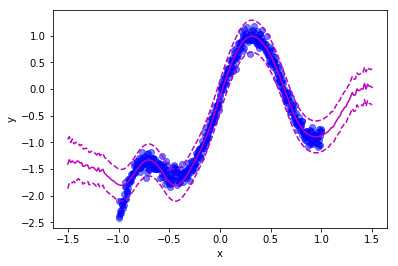

In [18]:
plt.figure(figsize=(16, 15))
plt.plot(X_train, y_train, 'bo', alpha=0.5)
plt.plot(X_plot, m, 'm-')
plt.plot(X_plot, m-2*np.sqrt(v), 'm--')
plt.plot(X_plot, m+2*np.sqrt(v), 'm--')
plt.xlabel('x')
plt.ylabel('y')
plt.show()